In [1]:
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os, shutil
import time
import scipy
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from keras import models
from keras import layers
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix


# Now lets try and to make the results better

In [2]:
# Create a data generator
datagen2 = ImageDataGenerator(
    rescale=1./255, # normalize pixel values
    rotation_range=20, # randomly rotate images in the range
    zoom_range=0.2, # randomly zoom image 
    width_shift_range=0.2, # randomly shift images horizontally
    height_shift_range=0.2, # randomly shift images vertically 
    horizontal_flip=True) # randomly flip images

In [3]:
# Use flow_from_directory to read images from folders
train_generator2 = datagen2.flow_from_directory(
        'CellData/chest_xray/train', # point to the parent directory
        target_size=(299, 299), # resize images to 299x299
        batch_size=32,
        class_mode='binary') # binary for two classes

# Similarly create validation and test generators
val_generator2 = datagen2.flow_from_directory(
        'CellData/chest_xray/val',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary')

test_generator2 = datagen2.flow_from_directory(
        'CellData/chest_xray/test',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary',
        shuffle=False)


Found 4098 images belonging to 2 classes.
Found 879 images belonging to 2 classes.
Found 879 images belonging to 2 classes.


In [4]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64, (5, 5), activation='relu',
                        input_shape=(299 , 299,  3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

2023-07-14 11:02:45.241680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-14 11:02:45.243435: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro


In [5]:
from collections import Counter
import numpy as np

# Get class distribution
counter = Counter(train_generator2.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

print(counter)
print(max_val)
print(class_weights)

Counter({1: 2991, 0: 1107})
2991.0
{0: 2.7018970189701896, 1: 1.0}


In [6]:
epochs = 100

steps_per_epoch2 = np.ceil(train_generator2.samples / train_generator2.batch_size)
validation_steps2 = np.ceil(val_generator2.samples / val_generator2.batch_size)

history = model2.fit(
    train_generator2,
    steps_per_epoch=int(steps_per_epoch2),
    epochs=epochs,
    validation_data=val_generator2,
    validation_steps=int(validation_steps2),
    class_weight=class_weights)



Epoch 1/100


2023-07-14 11:02:50.597676: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-14 11:02:50.805370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 0.8085 - acc: 0.7013

2023-07-14 11:03:49.114426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 72s 548ms/step - loss: 0.8085 - acc: 0.7013 - val_loss: 0.4478 - val_acc: 0.8157
Epoch 2/100
129/129 [==============================] - 71s 544ms/step - loss: 0.6850 - acc: 0.7836 - val_loss: 0.4459 - val_acc: 0.8419
Epoch 3/100
129/129 [==============================] - 69s 529ms/step - loss: 0.6807 - acc: 0.7899 - val_loss: 0.4719 - val_acc: 0.8316
Epoch 4/100
129/129 [==============================] - 69s 530ms/step - loss: 0.6539 - acc: 0.7984 - val_loss: 0.3632 - val_acc: 0.8294
Epoch 5/100
129/129 [==============================] - 69s 530ms/step - loss: 0.6149 - acc: 0.8170 - val_loss: 0.3390 - val_acc: 0.8510
Epoch 6/100
129/129 [==============================] - 70s 543ms/step - loss: 0.5990 - acc: 0.8170 - val_loss: 0.4062 - val_acc: 0.8373
Epoch 7/100
129/129 [==============================] - 71s 551ms/step - loss: 0.5773 - acc: 0.8267 - val_loss: 0.3793 - val_acc: 0.8521
Epoch 8/100
129/129 [==============================] - 69s 5

Epoch 61/100
129/129 [==============================] - 69s 533ms/step - loss: 0.2557 - acc: 0.9305 - val_loss: 0.1759 - val_acc: 0.9386
Epoch 62/100
129/129 [==============================] - 69s 530ms/step - loss: 0.2450 - acc: 0.9329 - val_loss: 0.1691 - val_acc: 0.9340
Epoch 63/100
129/129 [==============================] - 69s 532ms/step - loss: 0.2523 - acc: 0.9278 - val_loss: 0.1648 - val_acc: 0.9420
Epoch 64/100
129/129 [==============================] - 69s 532ms/step - loss: 0.2567 - acc: 0.9329 - val_loss: 0.1989 - val_acc: 0.9397
Epoch 65/100
129/129 [==============================] - 69s 535ms/step - loss: 0.2497 - acc: 0.9290 - val_loss: 0.1552 - val_acc: 0.9511
Epoch 66/100
129/129 [==============================] - 69s 534ms/step - loss: 0.2312 - acc: 0.9329 - val_loss: 0.1749 - val_acc: 0.9352
Epoch 67/100
129/129 [==============================] - 69s 534ms/step - loss: 0.2238 - acc: 0.9378 - val_loss: 0.1464 - val_acc: 0.9568
Epoch 68/100
129/129 [===================

In [7]:
results_train = model2.evaluate(train_generator2)
results_test = model2.evaluate(val_generator2)
print('Training set performance:', results_train)
print('Validation set performance:', results_test)

28/28 [==============================] - 12s 432ms/step - loss: 0.1351 - acc: 0.9465
Training set performance: [0.12564069032669067, 0.952171802520752]
Validation set performance: [0.13510814309120178, 0.9465302228927612]


In [8]:
results_train = model2.evaluate(train_generator2)
results_test = model2.evaluate(val_generator2)
print('Training set performance:', results_train)
print('Validation set performance:', results_test)

28/28 [==============================] - 12s 437ms/step - loss: 0.1262 - acc: 0.9499
Training set performance: [0.11637527495622635, 0.9546120166778564]
Validation set performance: [0.12624768912792206, 0.9499431848526001]


In [21]:
model2.save('modelv10weighted.h5')  # creates a HDF5 file 'my_model.h5'

In [9]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 295, 295, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 147, 147, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 144, 64)      65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 70, 70, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

In [10]:

# Generate predictions
y_pred = model2.predict(test_generator2)

2023-07-14 13:00:32.346066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 12s 423ms/step


In [11]:
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator2.classes

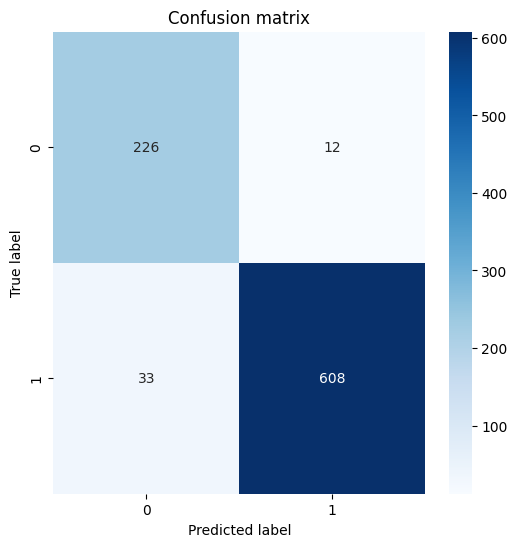

In [12]:

cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [13]:
from sklearn.metrics import classification_report



print(classification_report(y_true, y_pred, target_names=test_generator2.class_indices.keys()))


              precision    recall  f1-score   support

      NORMAL       0.87      0.95      0.91       238
   PNEUMONIA       0.98      0.95      0.96       641

    accuracy                           0.95       879
   macro avg       0.93      0.95      0.94       879
weighted avg       0.95      0.95      0.95       879



In [14]:
from sklearn.metrics import classification_report


# Convert continuous values to binary
y_pred_binary = [1 if p>=0.5 else 0 for p in y_pred]

tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

specificity = tn / (tn+fp)
print("Specificity: ", specificity)



print(classification_report(y_true, y_pred_binary, target_names=test_generator2.class_indices.keys()))

Specificity:  0.9495798319327731
              precision    recall  f1-score   support

      NORMAL       0.87      0.95      0.91       238
   PNEUMONIA       0.98      0.95      0.96       641

    accuracy                           0.95       879
   macro avg       0.93      0.95      0.94       879
weighted avg       0.95      0.95      0.95       879



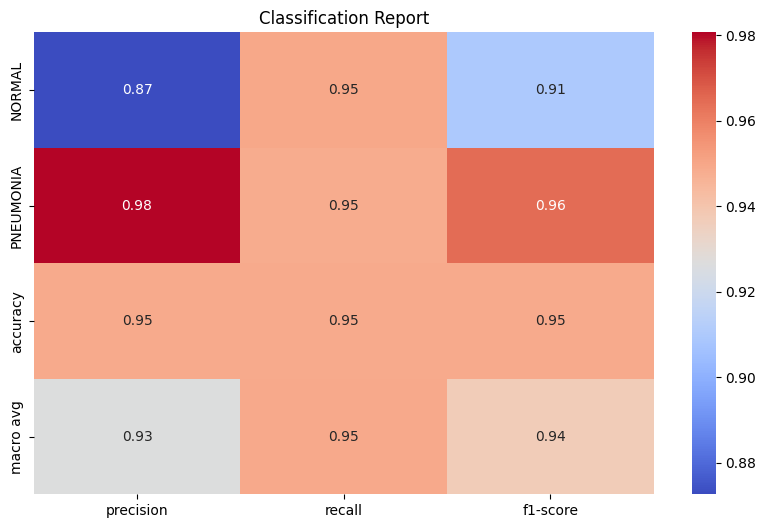

In [15]:

# Convert probabilities into binary outputs
y_pred_binary = [1 if y >= 0.5 else 0 for y in y_pred]

# Then use these binary predictions to compute the classification report
report = classification_report(y_true, y_pred_binary, target_names=test_generator2.class_indices.keys(), output_dict=True)

# Convert the report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Plot the heatmap
plt.figure(figsize=(10, 6)) 
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Classification Report")
plt.show()


28/28 [==============================] - 12s 425ms/step
0.9888566971250279


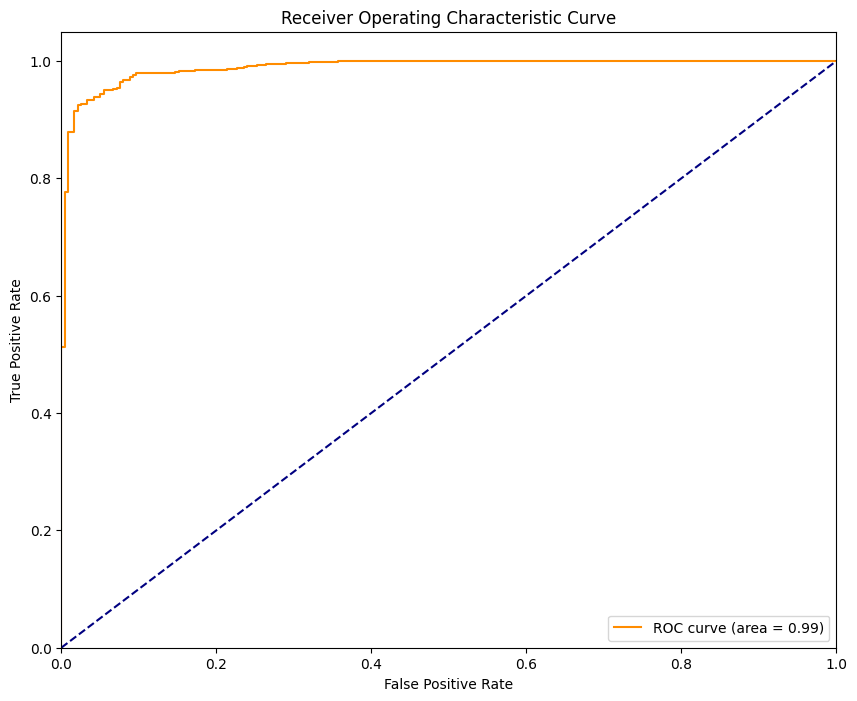

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming val_generator2 is your validation generator
test_generator2.reset()

# Generate predictions
y_pred_probs = model2.predict(test_generator2)

# Get true labels
y_true = test_generator2.classes

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Compute AUC
auc = roc_auc_score(y_true, y_pred_probs)
print(auc)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


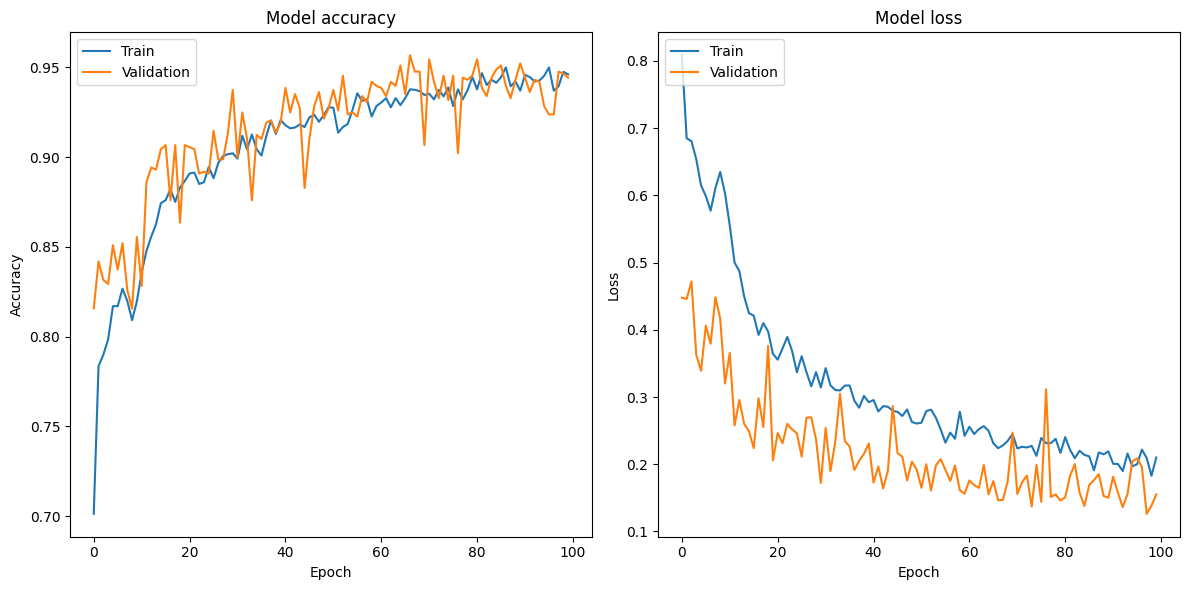

In [17]:


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [18]:
from tensorflow.keras.preprocessing import image



# Load the image
img = image.load_img('CellData/chest_xray/train/PNEUMONIA/BACTERIA-9074730-0001.jpeg', target_size=(299, 299))

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_preprocessed = img_array/255.


In [19]:
predictions = model2.predict(img_preprocessed)


2023-07-14 13:00:58.506655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 430ms/step


In [20]:
if predictions[0] > 0.5:
    print('The model predicts this image is of a PNEUMONIA case.')
else:
    print('The model predicts this image is of a NORMAL case.')


The model predicts this image is of a PNEUMONIA case.


## not bad, but not as good as the best model